In [1]:
%config InlineBackend.figure_format = 'svg'

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from cycler import cycler

colors = ["#00A6D6", "white", "#EC6842"]
tu_delft_diverging = LinearSegmentedColormap.from_list("tu_delft_diverging", colors)
tu_delft_qualitative = ListedColormap(
    [
        "#0076C2",
        "#EC6842",
        "#00B8C8",
        "#FFB81C",
        "#0C2340",
        "#009B77",
        "#6F1D77",
        "#A50034",
        "#E03C31",
    ],
    name="tu_delft_qualitative",
)
mpl.colormaps.register(cmap=tu_delft_diverging)
mpl.colormaps.register(cmap=tu_delft_qualitative)
plt.rc('axes', prop_cycle=cycler(color=tu_delft_qualitative.colors))

In [3]:
import numpy as np
import scipy.stats as stats
from myst_nb import glue

# Monte Carlo methods

## Approximation integrals

- Many calculations in probabilistic modeling and statistics involve the evaluation of integrals
  - expectation and variance
  - exceedance probability
  - marginal distribution
- If the variables we are interested in can be described by well-characterized parametric probability distributions, the integrals can be evaluated analytically. For example, closed form solution for the variance and CDF exist.
- More often, however, the integral cannot be evaluated analytically. Probability distribution may be more complex than the parametric distributions that we have names for.
- "Traditional" numerical integration (e.g., quadrature rules) is inefficient in higher dimensions.
- In these cases, we approximate the integration numerically using random samples.
  For example, we can calculate the mean and variance of a set of samples from a distribution.
  Or construct the empirical CDF to evaluate an exceedance probability.
  This is quite intuitive, because it is similar to what we are used to from calculating statistics of measurements.
- Using samples to approximate the integral is called Monte Carlo integration

### Monte Carlo estimator

Integral we want to approximate:

$$F = \int_a^b f(x) dx$$

Monte Carlo estimator:

$$\frac{(b - a)}{N} \sum_{i=0}^N f(X_i)$$

where $X_i\in [a, b)$ is a uniform random variable.

That is, we evaluate the function $f$ at random points in the interval $(a, b]$ and average the result.

- unbiased, i.e. the expectation of the Monte Carlo estimator is the true integral


### Error and convergence

## Generating samples


### Transformations of a random variable


- Consider two random variables. The second variable is obtained by transforming the first one.
- if we have samples from one distribution, we can obtain samples from the second one by applying the transformation to each sample


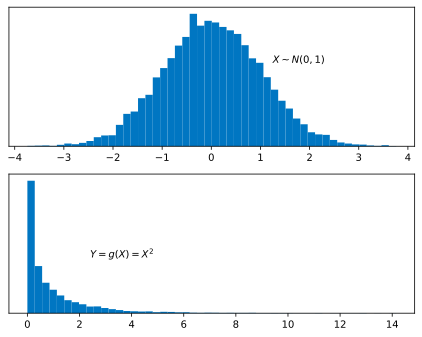

In [4]:
samples = stats.norm(0, 1).rvs(10000)
transformed = samples**2
fig, axs = plt.subplots(2, 1)
axs[0].hist(samples, bins=50)
axs[0].text(s=r"$X \sim N(0, 1)$", x=0.65, y=0.6, transform = axs[0].transAxes)
axs[1].hist(transformed, bins=50)
axs[1].text(s="$Y = g(X) = X^{2}$", x=0.2, y=0.4, transform = axs[1].transAxes)
plt.tight_layout()
for a in axs.flat:
    a.set_yticks([])
glue("transform_samples_fig", plt.gcf(), display=False)

```{glue:figure} transform_samples_fig
:width: 100%
:name: "fig-transform-samples"

This is a **caption**.
```


### Inverse sampling

You have:​
- Random variable X with density f(x)​
- A closed-form solution for the CDF F(x)​
- CDF is invertible​
- Random samples from a uniform distribution

- special case of transforming a distribution: CDF is a transformation function
- CDF of a random variable follows a uniform distribution
- Approach: Generate random uniform samples, then apply inverse CDF as a transformation

- this is commonly used e.g. in scipy
- mostly in 1-D


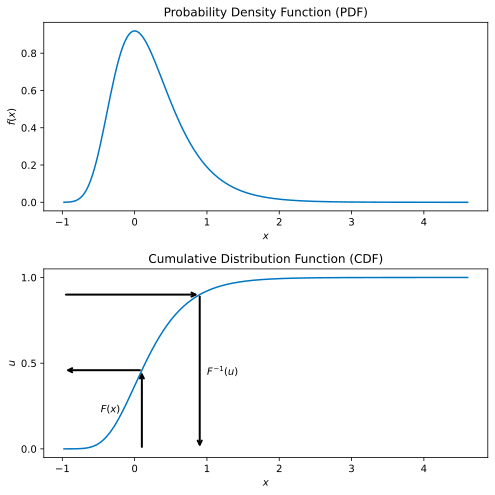

In [5]:
dist = stats.gumbel_r(scale=0.4)

alpha = 1e-5
x = np.linspace(dist.ppf(alpha), dist.ppf(1-alpha), num=200)
u = dist.cdf(x)
p = dist.pdf(x)

# Set up the subplot figure for PDF and CDF side by side
fig, ax = plt.subplots(2, 1, figsize=(7, 7))

# Left subplot: PDF
ax[0].plot(x, p)
ax[0].set_xlabel("$x$")
ax[0].set_ylabel(r"$f(x)$")
ax[0].set_title("Probability Density Function (PDF)")

# Right subplot: CDF with transformation arrows
ax[1].plot(x, u)
ax[1].set_xlabel("$x$")
ax[1].set_ylabel(r"$u$")
ax[1].set_title("Cumulative Distribution Function (CDF)")

# Annotate transformation from x to F(x)
x_value = 0.1  # Example x-value for arrow
u_value = dist.cdf(x_value)

ax[1].annotate(
    "",
    xy=(x_value, u_value),
    xytext=(x_value, 0),
    arrowprops=dict(arrowstyle="->", color="black", lw=2),
)
ax[1].annotate(
    "",
    xytext=(x_value, u_value),
    xy=(x[0], u_value),
    arrowprops=dict(arrowstyle="->", color="black", lw=2),
)
ax[1].text(x_value - 0.3, u_value / 2, "$F(x)$", ha="right", va="center", color="black")
plt.yticks([0, 0.5, 1])

# Annotate transformation from u to F(u)
u_value = 0.9  # Example x-value for arrow
x_value = dist.ppf(u_value)

ax[1].annotate(
    "",
    xytext=(x_value, u_value),
    xy=(x_value, 0),
    arrowprops=dict(arrowstyle="->", color="black", lw=2),
)
ax[1].annotate(
    "",
    xy=(x_value, u_value),
    xytext=(x[0], u_value),
    arrowprops=dict(arrowstyle="->", color="black", lw=2),
)
ax[1].text(
    x_value + 0.1, u_value / 2, "$F^{-1}(u)$", ha="left", va="center", color="black"
)
plt.yticks([0, 0.5, 1])

fig.tight_layout()

glue("inverse_sampling_fig", fig, display=False)

```{glue:figure} inverse_sampling_fig
:width: 100%
:name: "fig-inverse-sampling"

This is a **caption**.
```


## Rejection sampling

- General idea: Generate samples from a known distribution (the so-called proposal distribution), then "correct" the samples.
- Correction is done by comparing the pdf of the proposal to the target pdf

### Algorithm

1. Define a proposal distribution with density $q(x)$.
2. Scale the proposal density such that is always larger than the target density: $\quad Mq(x) \geq p(x) \quad \forall x$
3. Generate a sample $x$ from the proposal distribution.
4. Sample $u \sim \text{Uniform}(0, M q(x))$.
5. Accept $x$ if $u \leq p(x)$. Otherwise, reject.

In [6]:
# Define the target distribution
def evaluate_target_pdf(x):
    """Target distribution with two peaks."""
    return 0.3 * np.exp(-0.2 * (x - 2) ** 2) + 0.7 * np.exp(-0.2 * (x + 2) ** 2)


def evaluate_proposal_pdf(x):
    return proposal.pdf(x)


def get_proposal_samples(N):
    return proposal.rvs(N)

def rejection_sampling(N, evaluate_target_pdf, evaluate_proposal_pdf, get_proposal_samples):
    # Generate samples from the proposal distribution
    proposal_samples = get_proposal_samples(N)
    
    # Compute the target and proposal pdf for each sample
    target_pdf = evaluate_target_pdf(proposal_samples)
    proposal_pdf = evaluate_proposal_pdf(proposal_samples)
    
    # Compute the ratio of the pdfs
    ratio = target_pdf / proposal_pdf
    
    # Determine the scaling constant
    M = ratio.max()
    
    # Accept or reject samples based on the ratio of the pdfs
    u = stats.uniform.rvs(size=N)
    accept = u < ratio / M
    return proposal_samples, proposal_pdf, u, accept, M

In [7]:
N = 1000
proposal = stats.norm(loc=0, scale=3)
proposal_samples, proposal_pdf, u, accept, M = rejection_sampling(
    N, evaluate_target_pdf, evaluate_proposal_pdf, get_proposal_samples
)

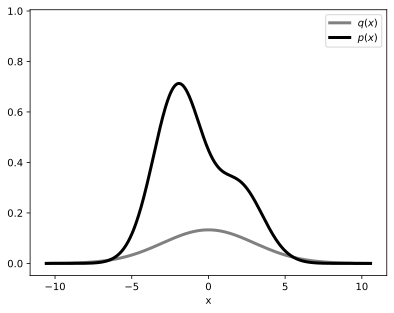

In [8]:
x_lim = np.max(np.abs(proposal_samples))
x = np.linspace(-x_lim, x_lim, 500)
plt.plot(x, evaluate_proposal_pdf(x) * M, lw=3, color="grey", alpha=0)
plt.plot(x, evaluate_proposal_pdf(x), label="$q(x)$", lw=3, color="grey",)
plt.plot(x, evaluate_target_pdf(x), label="$p(x)$", lw=3, color="k")
plt.legend()
plt.xlabel("x")
glue("rejection_sampling_fig_1", plt.gcf(), display=False)

```{glue:figure} rejection_sampling_fig_1
:width: 50%
:name: "fig-rejection-sampling-1"

This is a **caption**.
```

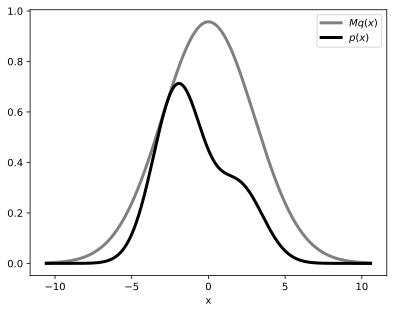

In [9]:
x_lim = np.max(np.abs(proposal_samples))
x = np.linspace(-x_lim, x_lim, 500)
plt.plot(x, evaluate_proposal_pdf(x) * M, label="$M q(x)$", lw=3, color="grey",)
plt.plot(x, evaluate_target_pdf(x), label="$p(x)$", lw=3, color="k")
plt.legend()
plt.xlabel("x")
glue("rejection_sampling_fig_2", plt.gcf(), display=False)

```{glue:figure} rejection_sampling_fig_2
:width: 50%
:name: "fig-rejection-sampling-2"

This is a **caption**.
```

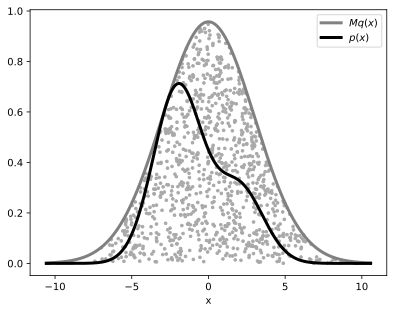

In [10]:
plt.plot(x, evaluate_proposal_pdf(x) * M, label="$M q(x)$", lw=3, color="grey",)
plt.plot(x, evaluate_target_pdf(x), label="$p(x)$", lw=3, color="k")
plt.scatter(
    proposal_samples,
    M * proposal_pdf * u,
    color="darkgrey",
    s=7,
)
plt.legend()
plt.xlabel("x")
glue("rejection_sampling_fig_3", plt.gcf(), display=False)

```{glue:figure} rejection_sampling_fig_3
:width: 50%
:name: "fig-rejection-sampling-3"

This is a **caption**.
```

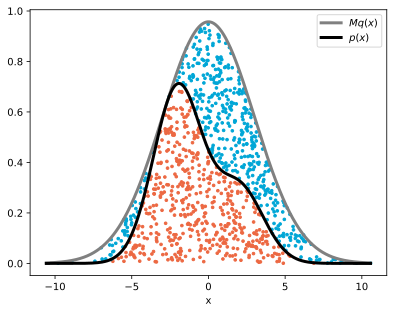

In [11]:
plt.plot(x, evaluate_proposal_pdf(x) * M, label="$M q(x)$", lw=3, color="grey",)
plt.plot(x, evaluate_target_pdf(x), label="$p(x)$", lw=3, color="k")
plt.scatter(
    proposal_samples,
    M * proposal_pdf * u,
    c=accept,
    s=7,
    cmap="tu_delft_diverging"
)
plt.legend()
plt.xlabel("x")
glue("rejection_sampling_fig_4", plt.gcf(), display=False)

```{glue:figure} rejection_sampling_fig_4
:width: 50%
:name: "fig-rejection-sampling-4"

This is a **caption**.
```

Rejection sampling becomes very inefficient

- when the proposal distribution does not approximate the target distribution well,
- in higher dimension.

## Importance sampling